# Postcode dataset add lsoa code

In [17]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

def transform_postcode_to_lsoa(df, postcode_column, lookup_file, output_dir="data/preprocessed", source_file=None):
    """
    Transform postcodes to LSOA codes using the GM lookup table and add the LSOA code column
    to the dataset. Then proceed with analyzing the enhanced dataset.

    Parameters:
    df (pd.DataFrame): Dataset containing postcodes
    postcode_column (str): Name of the column containing postcodes
    lookup_file (str): Path to the GM lookup CSV file
    output_dir (str): Directory to save output files and visualizations

    Returns:
    pd.DataFrame: Dataset with added LSOA codes and analysis
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Extract dataset name from source_file if provided
    if source_file:
        dataset_name = os.path.basename(source_file).split('.')[0]
    else:
        dataset_name = "transformed_dataset"

    # Generate a timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    print(f"Processing dataset with postcode to LSOA transformation")
    print(f"Original dataset shape: {df.shape}")

    # Standardize column names in the original dataframe
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    postcode_column = postcode_column.lower().replace(' ', '_')

    # Make sure postcode column exists
    if postcode_column not in df.columns:
        raise ValueError(f"Postcode column '{postcode_column}' not found in dataset. Available columns: {df.columns.tolist()}")

    # Load the GM lookup table
    print(f"Loading lookup table from: {lookup_file}")
    lookup_df = pd.read_csv(lookup_file)

    # Clean postcodes in original dataset (remove spaces, uppercase)
    df[postcode_column] = df[postcode_column].astype(str).str.upper().str.strip()

    # Standardize formats - format postcodes with or without spaces for matching
    # Create two formats - with and without space
    df['postcode_nospace'] = df[postcode_column].str.replace(' ', '')

    # Create a standardized format with space before the last 3 characters
    def format_postcode_with_space(pc):
        pc = pc.strip().upper().replace(' ', '')
        if len(pc) > 3:
            return pc[:-3] + ' ' + pc[-3:]
        return pc

    df['postcode_withspace'] = df[postcode_column].apply(format_postcode_with_space)

    # Prepare the lookup dataframe - focus on the columns we need
    postcode_cols = ['postcode_7char', 'postcode_8char', 'postcode_full']
    lsoa_col = 'lsoa_code'

    # Create lookup dictionaries for each postcode format
    lookup_dict = {}
    for pc_col in postcode_cols:
        # Create a dictionary mapping from each postcode format to LSOA code
        temp_dict = dict(zip(lookup_df[pc_col].str.upper().str.strip(), lookup_df[lsoa_col]))
        lookup_dict.update(temp_dict)

    # Create a dictionary for no-space postcodes as well
    nospace_dict = dict(zip(lookup_df['postcode_full'].str.upper().str.replace(' ', ''), lookup_df[lsoa_col]))
    lookup_dict.update(nospace_dict)

    # Now map postcodes to LSOA codes using multiple formats to maximize matches
    # Try matching with space first
    df['lsoa_code'] = df['postcode_withspace'].map(lookup_dict)

    # For any missing matches, try without space
    df.loc[df['lsoa_code'].isna(), 'lsoa_code'] = df.loc[df['lsoa_code'].isna(), 'postcode_nospace'].map(nospace_dict)

    # For any still missing, try the original format
    df.loc[df['lsoa_code'].isna(), 'lsoa_code'] = df.loc[df['lsoa_code'].isna(), postcode_column].map(lookup_dict)

    # Remove the temporary postcode columns
    df = df.drop(['postcode_nospace', 'postcode_withspace'], axis=1)

    # Check how many postcodes were matched
    matched_count = df['lsoa_code'].notna().sum()
    total_count = len(df)
    match_rate = matched_count / total_count if total_count > 0 else 0

    print(f"Postcode to LSOA matching results:")
    print(f"Total records: {total_count}")
    print(f"Matched records: {matched_count} ({match_rate:.2%})")
    print(f"Unmatched records: {total_count - matched_count} ({1 - match_rate:.2%})")

    # Generate visualization for matching results
    plt.figure(figsize=(10, 6))
    match_data = pd.Series({
        'Matched': matched_count,
        'Unmatched': total_count - matched_count
    })
    match_data.plot(kind='pie', autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'])
    plt.title('Postcode to LSOA Match Rate', fontsize=16)
    plt.ylabel('')  # Hide the ylabel
    plt.tight_layout()
    plt.savefig(f"{output_dir}/postcode_to_lsoa_match_rate_{timestamp}.png", dpi=300)

    # Now pass the enhanced dataset with LSOA codes to the original analysis function
    lsoa_column_name = 'lsoa_code'
    return analyze_lsoa_dataset(df, lsoa_column_name, output_dir, dataset_name)

def analyze_lsoa_dataset(df, lsoa_column_name, output_dir="data/preprocessed", source_file=None):
    """
    Process a dataset that already contains LSOA codes, analyze missing values,
    and generate visualizations for reporting.

    Parameters:
    df (pd.DataFrame): Dataset containing LSOA codes (can be passed directly)
    lsoa_column_name (str): Name of the column containing LSOA codes
    output_dir (str): Directory to save output files and visualizations

    Returns:
    pd.DataFrame: Cleaned dataset with standardized LSOA codes
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Generate a timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Extract dataset name from source_file if provided
    if source_file:
        dataset_name = os.path.basename(source_file).split('.')[0]
    else:
        dataset_name = "transformed_dataset"

    print(f"Processing dataset '{dataset_name}' with LSOA analysis")
    print(f"Dataset shape: {df.shape}")

    # Save a summary of the original dataset
    with open(f"{output_dir}/{dataset_name}_{timestamp}_summary.txt", "w") as f:
        f.write(f"Dataset Analysis\n")
        f.write(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Original dataset shape: {df.shape}\n\n")
        f.write("Column Names:\n")
        for col in df.columns:
            f.write(f"- {col}\n")
        f.write("\n")

    # Basic data cleaning
    # 1. Remove duplicate rows
    df_clean = df.drop_duplicates()
    duplicates_removed = len(df) - len(df_clean)
    print(f"Removed {duplicates_removed} duplicate rows. New shape: {df_clean.shape}")

    # 2. Standardize column names
    original_columns = df_clean.columns.tolist()
    df_clean.columns = [col.lower().replace(' ', '_') for col in df_clean.columns]
    lsoa_column_name = lsoa_column_name.lower().replace(' ', '_')

    # 3. Handle the LSOA column
    # Make sure LSOA column exists
    if lsoa_column_name not in df_clean.columns:
        raise ValueError(f"LSOA column '{lsoa_column_name}' not found in dataset. Available columns: {df_clean.columns.tolist()}")

    # Standardize LSOA codes (ensure proper format E01######)
    df_clean[lsoa_column_name] = df_clean[lsoa_column_name].astype(str)

    # Clean LSOA codes (remove spaces, ensure proper format)
    df_clean[lsoa_column_name] = df_clean[lsoa_column_name].str.strip()

    # Check for and fix common LSOA format issues
    # Example: Add 'E01' prefix if it's just numeric and 6 digits
    def standardize_lsoa(lsoa_code):
        # Skip NaN values
        if lsoa_code.lower() in ['nan', 'none', '']:
            return np.nan

        # Remove any spaces or special characters
        lsoa_code = re.sub(r'[^a-zA-Z0-9]', '', lsoa_code)

        # If it's a numeric string of exactly 6 digits, add 'E01' prefix
        if lsoa_code.isdigit() and len(lsoa_code) == 6:
            return 'E01' + lsoa_code

        # If it already has the proper format (E01 followed by 6 digits)
        if re.match(r'^E01\d{6}$', lsoa_code):
            return lsoa_code

        # Otherwise, return the original code but flag it
        if lsoa_code != '':
            print(f"Potential incorrect LSOA code: {lsoa_code}")
        return lsoa_code

    df_clean[lsoa_column_name] = df_clean[lsoa_column_name].apply(standardize_lsoa)

    # Count standardized vs non-standardized LSOA codes
    standardized_lsoa_count = df_clean[lsoa_column_name].apply(
        lambda x: bool(isinstance(x, str) and re.match(r'^E01\d{6}$', x))
    ).sum()

    print(f"Standardized LSOA codes: {standardized_lsoa_count}/{len(df_clean)} ({standardized_lsoa_count/len(df_clean):.2%})")

    # 4. Analyze missing values across all columns
    missing_values = df_clean.isna().sum()
    missing_percentage = (missing_values / len(df_clean)) * 100
    missing_df = pd.DataFrame({
        'Column': missing_values.index,
        'Missing Values': missing_values.values,
        'Percentage': missing_percentage.values
    })
    missing_df = missing_df.sort_values('Missing Values', ascending=False).reset_index(drop=True)

    # Save missing values report
    missing_df.to_csv(f"{output_dir}/{dataset_name}_{timestamp}_missing_values.csv", index=False)

    print("\nMissing Values Analysis:")
    print(missing_df)

    # 5. Generate visualizations for the report

    # 5.1 Missing values heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(df_clean.isna(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title('Missing Values Heatmap', fontsize=16)
    plt.xlabel('Columns', fontsize=12)
    plt.ylabel('Records', fontsize=12)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{dataset_name}_{timestamp}_missing_heatmap.png", dpi=300)

    # 5.2 Bar chart of missing values by column
    plt.figure(figsize=(14, 8))
    top_missing = missing_df[missing_df['Missing Values'] > 0].head(20)  # Top 20 columns with missing values

    if not top_missing.empty:
        sns.barplot(x='Percentage', y='Column', data=top_missing)
        plt.title('Percentage of Missing Values by Column', fontsize=16)
        plt.xlabel('Missing Values (%)', fontsize=12)
        plt.ylabel('Column', fontsize=12)
        plt.tight_layout()
        plt.savefig(f"{output_dir}/{dataset_name}_{timestamp}_missing_barchart.png", dpi=300)
    else:
        print("No missing values to plot")

    # 5.3 LSOA code quality visualization
    plt.figure(figsize=(10, 6))
    lsoa_quality = pd.Series({
        'Valid Format': standardized_lsoa_count,
        'Invalid/Missing': len(df_clean) - standardized_lsoa_count
    })
    lsoa_quality.plot(kind='pie', autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'])
    plt.title('LSOA Code Quality', fontsize=16)
    plt.ylabel('')  # Hide the ylabel
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{dataset_name}_{timestamp}_lsoa_quality.png", dpi=300)

    # 6. Data type analysis
    dtypes_dict = {str(col): str(dtype) for col, dtype in zip(df_clean.columns, df_clean.dtypes)}
    dtypes_df = pd.DataFrame({
        'Column': list(dtypes_dict.keys()),
        'Data Type': list(dtypes_dict.values())
    })
    dtypes_df.to_csv(f"{output_dir}/{dataset_name}_{timestamp}_data_types.csv", index=False)

    # 7. Save the cleaned dataset
    cleaned_file_path = f"{output_dir}/{dataset_name}_cleaned.csv"
    df_clean.to_csv(cleaned_file_path, index=False)
    print(f"\nCleaned dataset saved to: {cleaned_file_path}")

    # 8. Generate a comprehensive report
    with open(f"{output_dir}/{dataset_name}_{timestamp}_report.txt", "w") as f:
        f.write(f"LSOA Dataset Analysis Report\n")
        f.write(f"===========================\n\n")
        f.write(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

        f.write(f"Dataset Statistics:\n")
        f.write(f"------------------\n")
        f.write(f"Original records: {len(df)}\n")
        f.write(f"Cleaned records: {len(df_clean)}\n")
        f.write(f"Duplicates removed: {duplicates_removed}\n")
        f.write(f"Total columns: {len(df_clean.columns)}\n\n")

        f.write(f"LSOA Code Analysis:\n")
        f.write(f"-----------------\n")
        f.write(f"LSOA column: {lsoa_column_name}\n")
        f.write(f"Records with standardized LSOA codes: {standardized_lsoa_count} ({standardized_lsoa_count/len(df_clean):.2%})\n")
        f.write(f"Records with invalid or missing LSOA codes: {len(df_clean) - standardized_lsoa_count} ({(len(df_clean) - standardized_lsoa_count)/len(df_clean):.2%})\n\n")

        f.write(f"Missing Values Summary:\n")
        f.write(f"---------------------\n")
        f.write(f"Columns with no missing values: {sum(missing_values == 0)}\n")
        f.write(f"Columns with missing values: {sum(missing_values > 0)}\n\n")

        if sum(missing_values > 0) > 0:
            f.write("Top 10 columns with most missing values:\n")
            for i, row in missing_df[missing_df['Missing Values'] > 0].head(10).iterrows():
                f.write(f"- {row['Column']}: {row['Missing Values']} values ({row['Percentage']:.2f}%)\n")

        f.write("\nGenerated Visualizations:\n")
        f.write(f"------------------------\n")
        f.write(f"1. Missing Values Heatmap: {dataset_name}_{timestamp}_missing_heatmap.png\n")
        if not top_missing.empty:
            f.write(f"2. Missing Values Bar Chart: {dataset_name}_{timestamp}_missing_barchart.png\n")
        f.write(f"3. LSOA Code Quality Pie Chart: {dataset_name}_{timestamp}_lsoa_quality.png\n")

        f.write("\nNext Steps Recommendation:\n")
        f.write(f"------------------------\n")
        if (len(df_clean) - standardized_lsoa_count)/len(df_clean) > 0.05:
            f.write("- High priority: Address the invalid or missing LSOA codes (>5% of dataset)\n")

        if missing_df['Percentage'].max() > 10:
            f.write("- Consider imputation strategies for columns with >10% missing values\n")

        f.write("- Review data types and ensure they are appropriate for analysis\n")
        f.write("- Consider spatial validation with Greater Manchester LSOA boundaries\n")
        f.write("- For remaining unmatched postcodes, consider additional lookup strategies or manual verification\n")

    print(f"\nAnalysis report saved to: {output_dir}/{dataset_name}_{timestamp}_report.txt")

    return df_clean, {
        'cleaned_file': cleaned_file_path,
        'report_file': f"{output_dir}/{dataset_name}_{timestamp}_report.txt",
        'missing_heatmap': f"{output_dir}/{dataset_name}_{timestamp}_missing_heatmap.png",
        'lsoa_quality': f"{output_dir}/{dataset_name}_{timestamp}_lsoa_quality.png"
    }


### Special health authorities

Processing dataset with postcode to LSOA transformation
Original dataset shape: (15, 27)
Loading lookup table from: data/gm_lookup.csv
Postcode to LSOA matching results:
Total records: 15
Matched records: 1 (6.67%)
Unmatched records: 14 (93.33%)
Processing dataset 'special_health_authorities_with_headers' with LSOA analysis
Dataset shape: (15, 28)
Removed 0 duplicate rows. New shape: (15, 28)
Standardized LSOA codes: 1/15 (6.67%)

Missing Values Analysis:
                      Column  Missing Values  Percentage
0                    null_15              15  100.000000
1                    null_21              15  100.000000
2                    null_16              15  100.000000
3                    null_19              15  100.000000
4                    null_14              15  100.000000
5                    null_13              15  100.000000
6                 close_date              15  100.000000
7                    null_20              15  100.000000
8                    null_2

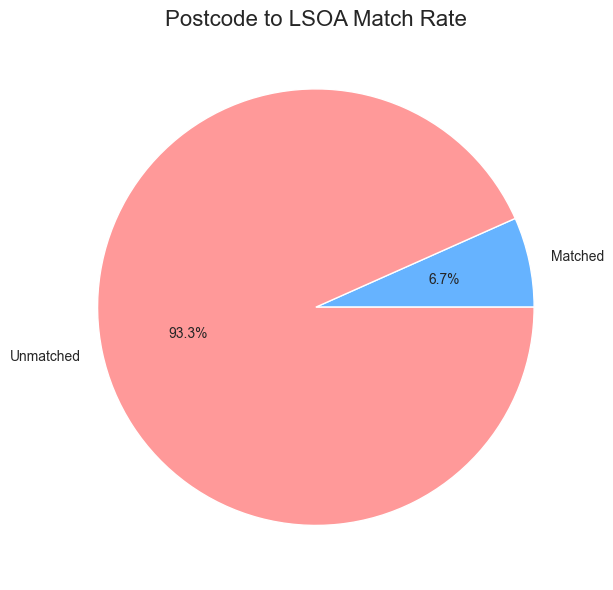

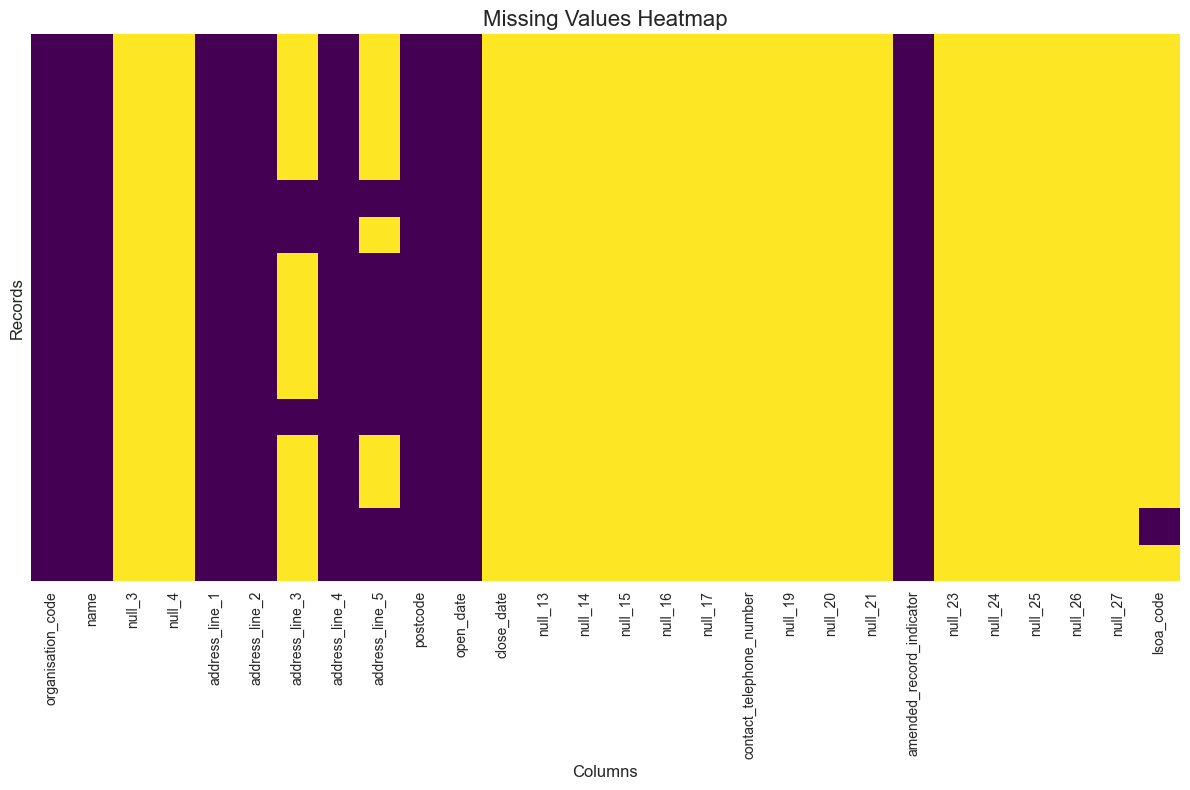

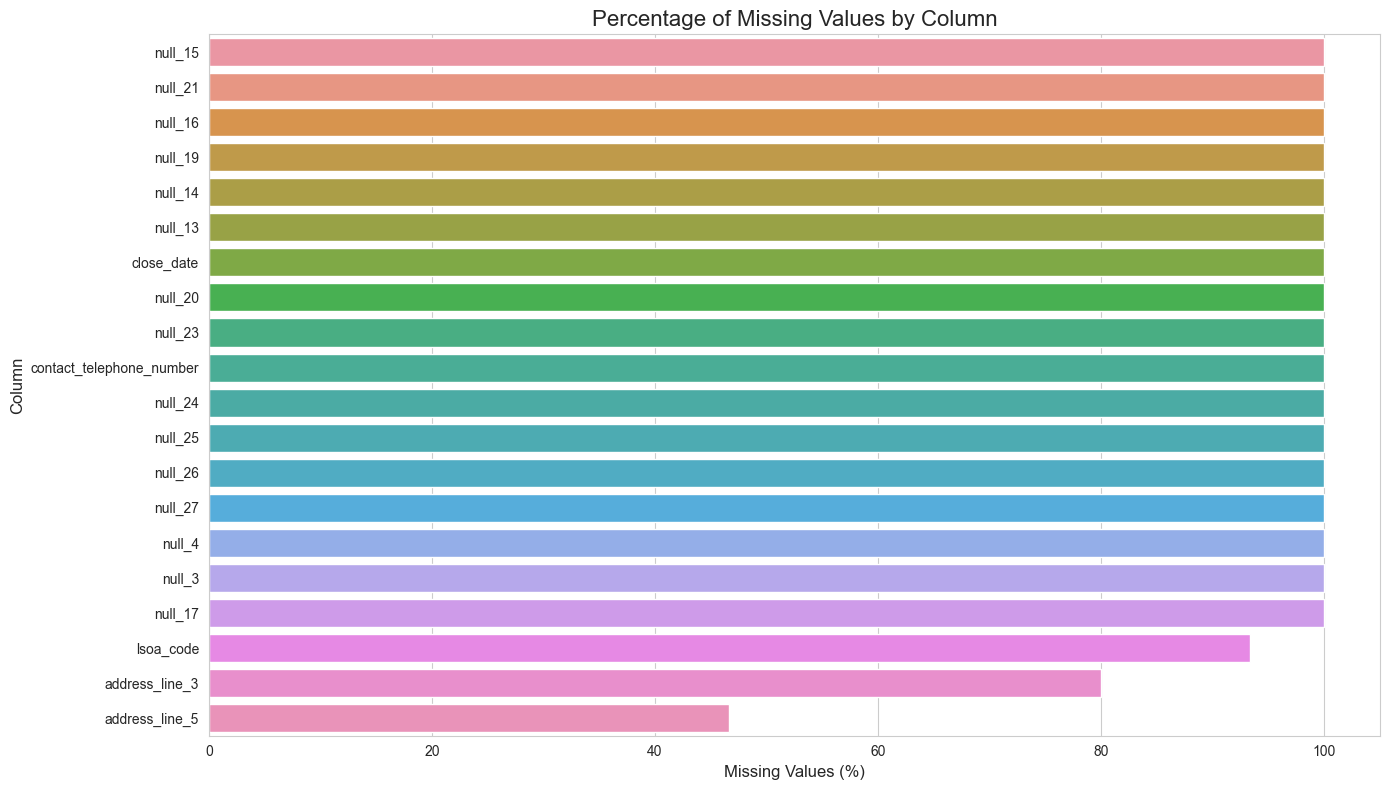

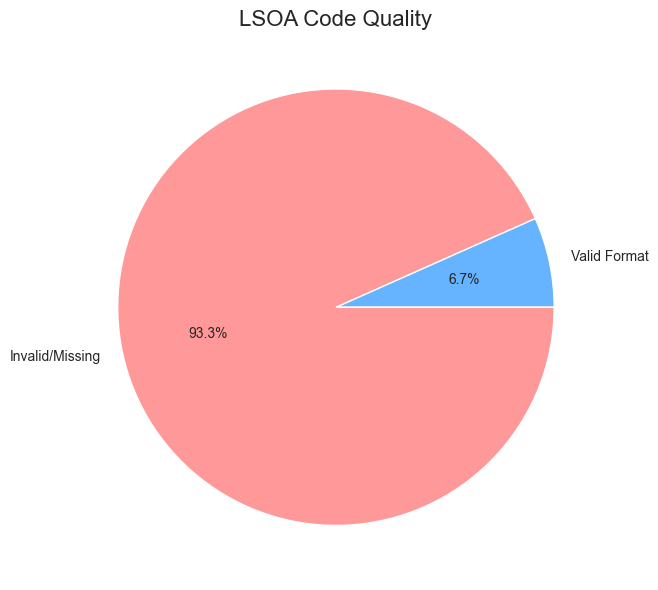

In [18]:
# Example usage function
def process_health_authorities_dataset():
    """
    Process the health authorities dataset by adding LSOA codes based on postcodes.
    """
    # Load the health authorities dataset
    health_authorities_file = "data/rawdata/health/special_health_authorities_with_headers.csv"
    health_authorities = pd.read_csv(health_authorities_file)

    # Set the path to the GM lookup file
    lookup_file = "data/gm_lookup.csv"

    # Set output directory for processed files
    output_dir = "data/preprocessed/health"

    # Transform postcodes to LSOA codes and analyze the dataset
    enhanced_df, artifacts = transform_postcode_to_lsoa(
        df=health_authorities,
        postcode_column="postcode",  # Use the actual column name from your dataset
        lookup_file=lookup_file,
        output_dir=output_dir,
        source_file=health_authorities_file  # Pass the actual file path
    )

    print(f"Processing complete. Enhanced dataset with LSOA codes saved to {artifacts['cleaned_file']}")

    # Additional Greater Manchester specific filtering
    # Filter for only Greater Manchester LSOAs if needed
    if 'lsoa_code' in enhanced_df.columns:
        # Check if the LSOA is in Greater Manchester (starts with 'E01')
        gm_lsoa_count = enhanced_df['lsoa_code'].str.startswith('E01').sum()
        print(f"Records with Greater Manchester LSOA codes: {gm_lsoa_count}/{len(enhanced_df)}")

    return enhanced_df, artifacts

# Run the function if this script is executed directly
if __name__ == "__main__":
    enhanced_df, artifacts = process_health_authorities_dataset()

In [29]:
df = pd.read_csv("data/preprocessed/health/special_health_authorities_with_headers_cleaned.csv")
df.head()

,organisation_code,name,null_3,null_4,address_line_1,address_line_2,address_line_3,address_line_4,address_line_5,postcode,...,null_19,null_20,null_21,amended_record_indicator,null_23,null_24,null_25,null_26,null_27,lsoa_code
0,L5X6M,DIGITAL HEALTH AND CARE WALES,NaN,NaN,TY GLAN-YR-AFON,21 COWBRIDGE ROAD EAST,NaN,CARDIFF,NaN,CF11 9AD,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
1,O7I9E,FOUNDATION PROGRAMME,NaN,NaN,K005 PAYABLES,PO BOX 312,NaN,LEEDS,NaN,LS11 1HP,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
2,S7E6C,NATIONAL ARTIFICIAL EYE SERVICE,NaN,NaN,221 BRISTOL AVENUE,BISPHAM,NaN,BLACKPOOL,NaN,FY2 0BF,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
3,T1150,NHS RESOLUTION,NaN,NaN,8TH FLOOR,10 SOUTH COLONNADE,NaN,LONDON,NaN,E14 4PU,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
4,T1450,NHS BUSINESS SERVICES AUTHORITY,NaN,NaN,STELLA HOUSE,GOLDCREST WAY,NEWBURN RIVERSIDE PARK,NEWCASTLE UPON TYNE,TYNE AND WEAR,NE15 8NY,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df.columns

Index(['organisation_code', 'name', 'null_3', 'null_4', 'address_line_1',
       'address_line_2', 'address_line_3', 'address_line_4', 'address_line_5',
       'postcode', 'open_date', 'close_date', 'null_13', 'null_14', 'null_15',
       'null_16', 'null_17', 'contact_telephone_number', 'null_19', 'null_20',
       'null_21', 'amended_record_indicator', 'null_23', 'null_24', 'null_25',
       'null_26', 'null_27', 'lsoa_code'],
      dtype='object')

In [31]:
# 1. Filter rows where lsoa_code is not null
df_filtered = df[df['lsoa_code'].notnull()]

# 2. Drop unnecessary columns — specify the ones you want to remove
columns_to_drop = ['null_3', 'null_4', 'address_line_1',
       'address_line_2', 'address_line_3', 'address_line_4', 'address_line_5'
       , 'open_date', 'close_date', 'null_13', 'null_14', 'null_15',
       'null_16', 'null_17', 'contact_telephone_number', 'null_19', 'null_20',
       'null_21', 'amended_record_indicator', 'null_23', 'null_24', 'null_25',
       'null_26', 'null_27']

df_cleaned = df_filtered.drop(columns=columns_to_drop)
df_cleaned.head()

,organisation_code,name,postcode,lsoa_code
13,T1560,NHS TRANSFORMATION UNIT,M1 2JB,E01033654


In [32]:
df_cleaned.to_csv('data/preprocessed/health/special_health_authorities_with_headers_cleaned2.csv', index=False)

### gp_practices

Processing dataset with postcode to LSOA transformation
Original dataset shape: (16534, 27)
Loading lookup table from: data/gm_lookup.csv
Postcode to LSOA matching results:
Total records: 16534
Matched records: 940 (5.69%)
Unmatched records: 15594 (94.31%)
Processing dataset 'gp_practices_with_headers' with LSOA analysis
Dataset shape: (16534, 28)
Removed 0 duplicate rows. New shape: (16534, 28)
Standardized LSOA codes: 940/16534 (5.69%)

Missing Values Analysis:
                          Column  Missing Values  Percentage
0                        null_27           16534  100.000000
1                        null_25           16534  100.000000
2                        null_23           16534  100.000000
3                        null_21           16534  100.000000
4                        null_20           16534  100.000000
5                        null_19           16534  100.000000
6                 address_line_5           16345   98.856901
7                      lsoa_code           1

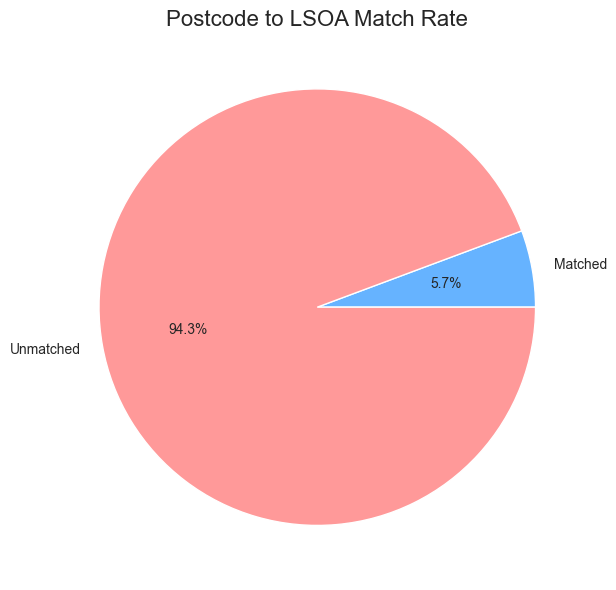

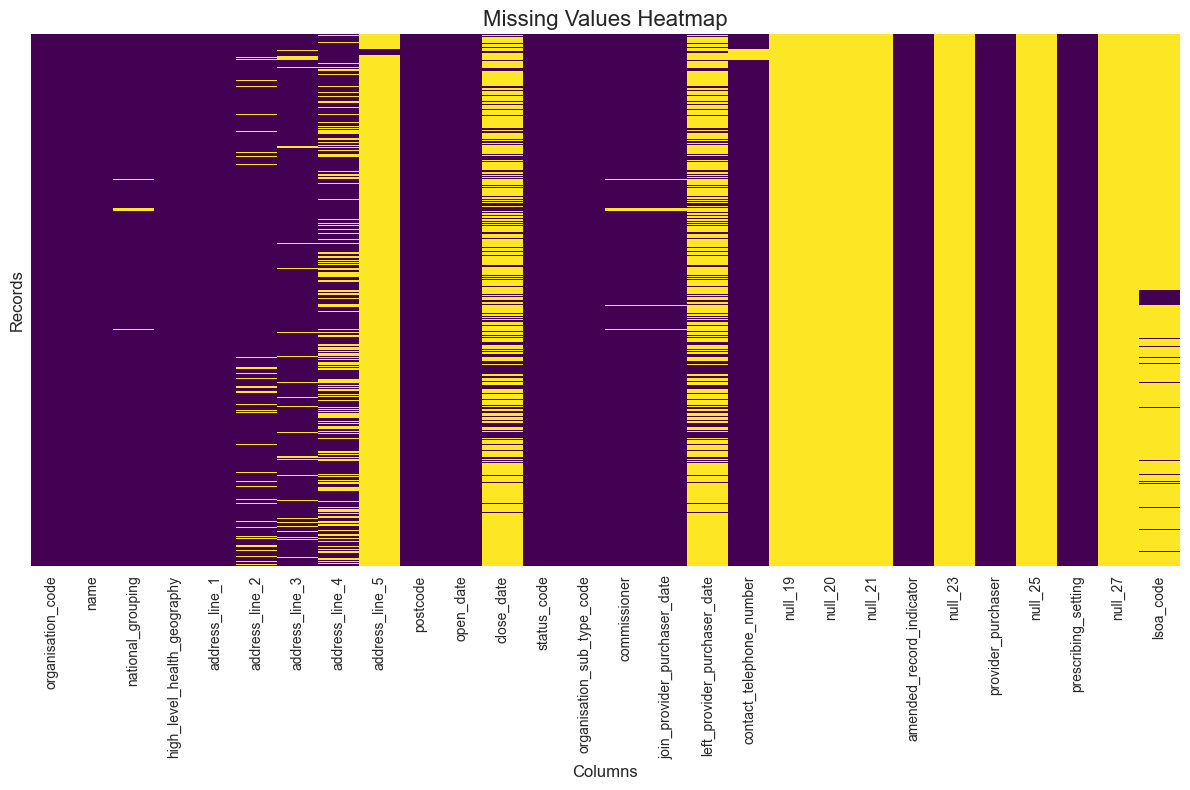

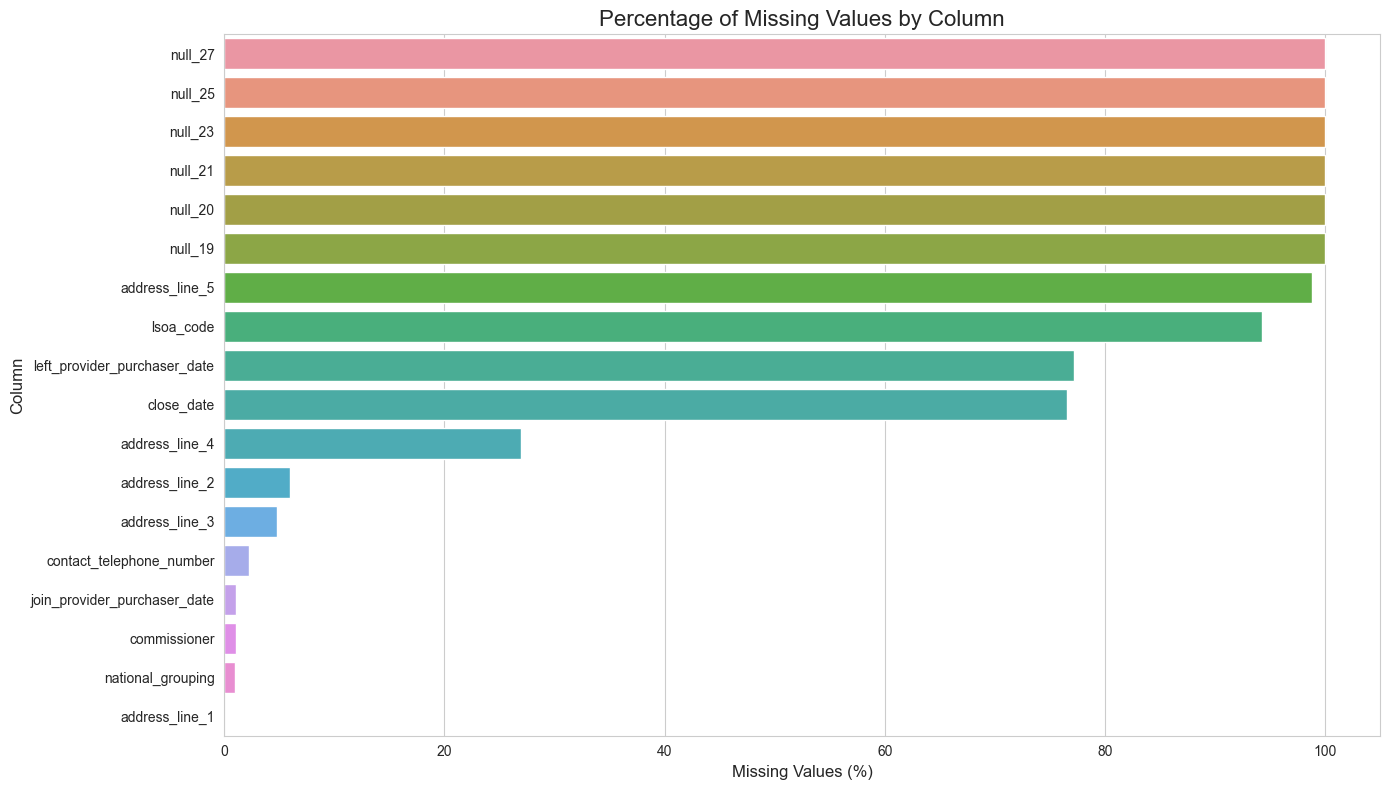

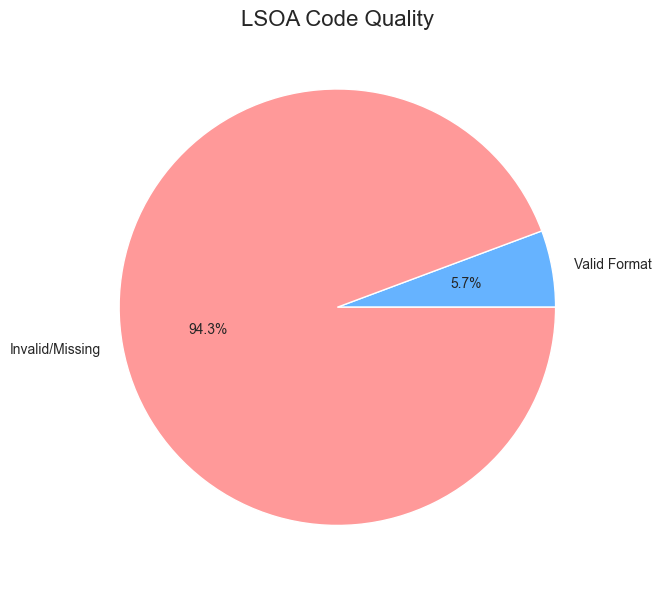

In [25]:
# Example usage function
def process_gp_practices_dataset():
    """
    Process the health authorities dataset by adding LSOA codes based on postcodes.
    """
    # Load the health authorities dataset
    gp_practices_file = "data/rawdata/health/gp_practices_with_headers.csv"
    gp_practices = pd.read_csv(gp_practices_file)

    # Set the path to the GM lookup file
    lookup_file = "data/gm_lookup.csv"

    # Set output directory for processed files
    output_dir = "data/preprocessed/health"

    # Transform postcodes to LSOA codes and analyze the dataset
    enhanced_df, artifacts = transform_postcode_to_lsoa(
        df=gp_practices,
        postcode_column="postcode",  # Use the actual column name from your dataset
        lookup_file=lookup_file,
        output_dir=output_dir,
        source_file=gp_practices_file  # Pass the actual file path
    )

    print(f"Processing complete. Enhanced dataset with LSOA codes saved to {artifacts['cleaned_file']}")

    # Additional Greater Manchester specific filtering
    # Filter for only Greater Manchester LSOAs if needed
    if 'lsoa_code' in enhanced_df.columns:
        # Check if the LSOA is in Greater Manchester (starts with 'E01')
        gm_lsoa_count = enhanced_df['lsoa_code'].str.startswith('E01').sum()
        print(f"Records with Greater Manchester LSOA codes: {gm_lsoa_count}/{len(enhanced_df)}")

    return enhanced_df, artifacts

# Run the function if this script is executed directly
if __name__ == "__main__":
    enhanced_df, artifacts = process_gp_practices_dataset()

In [26]:
df2 = pd.read_csv("data/preprocessed/health/gp_practices_with_headers_cleaned.csv")
df2.head()

,organisation_code,name,national_grouping,high_level_health_geography,address_line_1,address_line_2,address_line_3,address_line_4,address_line_5,postcode,...,null_19,null_20,null_21,amended_record_indicator,null_23,provider_purchaser,null_25,prescribing_setting,null_27,lsoa_code
0,A81001,THE DENSHAM SURGERY,Y63,QHM,THE HEALTH CENTRE,LAWSON STREET,STOCKTON ON TEES,CLEVELAND,NaN,TS18 1HU,...,NaN,NaN,NaN,0,NaN,16C,NaN,4,NaN,NaN
1,A81002,QUEENS PARK MEDICAL CENTRE,Y63,QHM,QUEENS PARK MEDICAL CTR,FARRER STREET,STOCKTON ON TEES,CLEVELAND,NaN,TS18 2AW,...,NaN,NaN,NaN,0,NaN,16C,NaN,4,NaN,NaN
2,A81003,VICTORIA MEDICAL PRACTICE,Y54,Q74,THE HEALTH CENTRE,VICTORIA ROAD,HARTLEPOOL,CLEVELAND,NaN,TS26 8DB,...,NaN,NaN,NaN,0,NaN,00K,NaN,4,NaN,NaN
3,A81004,ACKLAM MEDICAL CENTRE,Y63,QHM,TRIMDON AVENUE,ACKLAM,MIDDLESBROUGH,CLEVELAND,NaN,TS5 8SB,...,NaN,NaN,NaN,0,NaN,16C,NaN,4,NaN,NaN
4,A81005,SPRINGWOOD SURGERY,Y63,QHM,SPRINGWOOD SURGERY,RECTORY LANE,GUISBOROUGH,NaN,NaN,TS14 7DJ,...,NaN,NaN,NaN,0,NaN,16C,NaN,4,NaN,NaN


In [27]:
df2.columns

Index(['organisation_code', 'name', 'national_grouping',
       'high_level_health_geography', 'address_line_1', 'address_line_2',
       'address_line_3', 'address_line_4', 'address_line_5', 'postcode',
       'open_date', 'close_date', 'status_code', 'organisation_sub_type_code',
       'commissioner', 'join_provider_purchaser_date',
       'left_provider_purchaser_date', 'contact_telephone_number', 'null_19',
       'null_20', 'null_21', 'amended_record_indicator', 'null_23',
       'provider_purchaser', 'null_25', 'prescribing_setting', 'null_27',
       'lsoa_code'],
      dtype='object')

In [33]:
# 1. Filter rows where lsoa_code is not null
df2_filtered = df2[df2['lsoa_code'].notnull()]

# 2. Drop unnecessary columns — specify the ones you want to remove
columns_to_drop = ['national_grouping',
       'high_level_health_geography', 'address_line_1', 'address_line_2',
       'address_line_3', 'address_line_4', 'address_line_5',
       'open_date', 'close_date', 'status_code', 'organisation_sub_type_code',
       'commissioner', 'join_provider_purchaser_date',
       'left_provider_purchaser_date', 'contact_telephone_number', 'null_19',
       'null_20', 'null_21', 'amended_record_indicator', 'null_23',
       'provider_purchaser', 'null_25', 'prescribing_setting', 'null_27']

df2_cleaned = df2_filtered.drop(columns=columns_to_drop)
df2_cleaned.head()

,organisation_code,name,postcode,lsoa_code
680,A99889,CYGNET HOSPITAL BURY - BCSS INPATIENT UNIT,BL8 2BS,E01004948
723,A99932,PENNINE BCSC,BL9 7TD,E01004954
735,A99944,MANCHESTER BCSC,M13 9WL,E01034115
769,A99978,BOLTON BCSC,BL4 0JR,E01004880
7944,P82001,THE DUNSTAN PARTNERSHIP,BL2 6NT,E01004795


In [34]:
df2_cleaned.to_csv('data/preprocessed/health/gp_practices_with_headers_cleaned2.csv', index=False)

### GMAL

Processing dataset with postcode to LSOA transformation
Original dataset shape: (71036, 24)
Loading lookup table from: data/gm_lookup.csv
Postcode to LSOA matching results:
Total records: 71036
Matched records: 71034 (100.00%)
Unmatched records: 2 (0.00%)
Processing dataset 'gmal' with LSOA analysis
Dataset shape: (71036, 25)
Removed 0 duplicate rows. New shape: (71036, 25)
Standardized LSOA codes: 71034/71036 (100.00%)

Missing Values Analysis:
                      Column  Missing Values  Percentage
0                  lsoa_code               2    0.002815
1                     bolton               0    0.000000
2                      wigan               0    0.000000
3             traffordcentre               0    0.000000
4                  stockport               0    0.000000
5                   rochdale               0    0.000000
6                     oldham               0    0.000000
7   manchesterspinningfields               0    0.000000
8       manchesteroxfordroad         

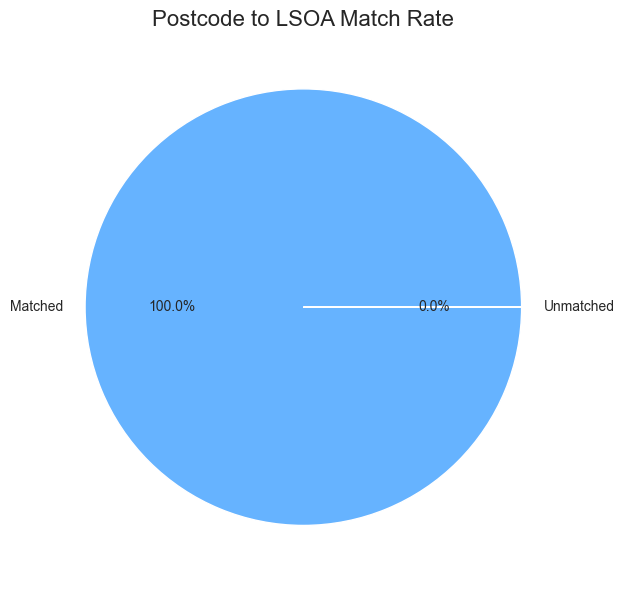

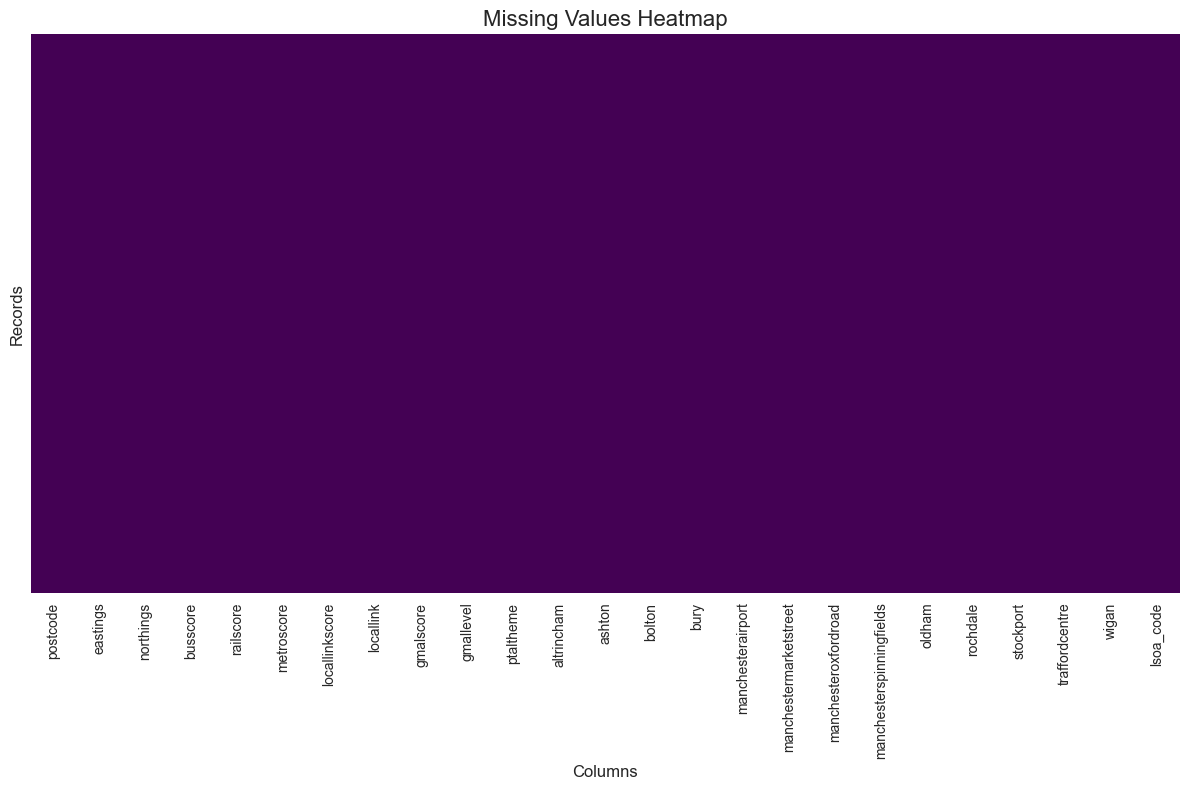

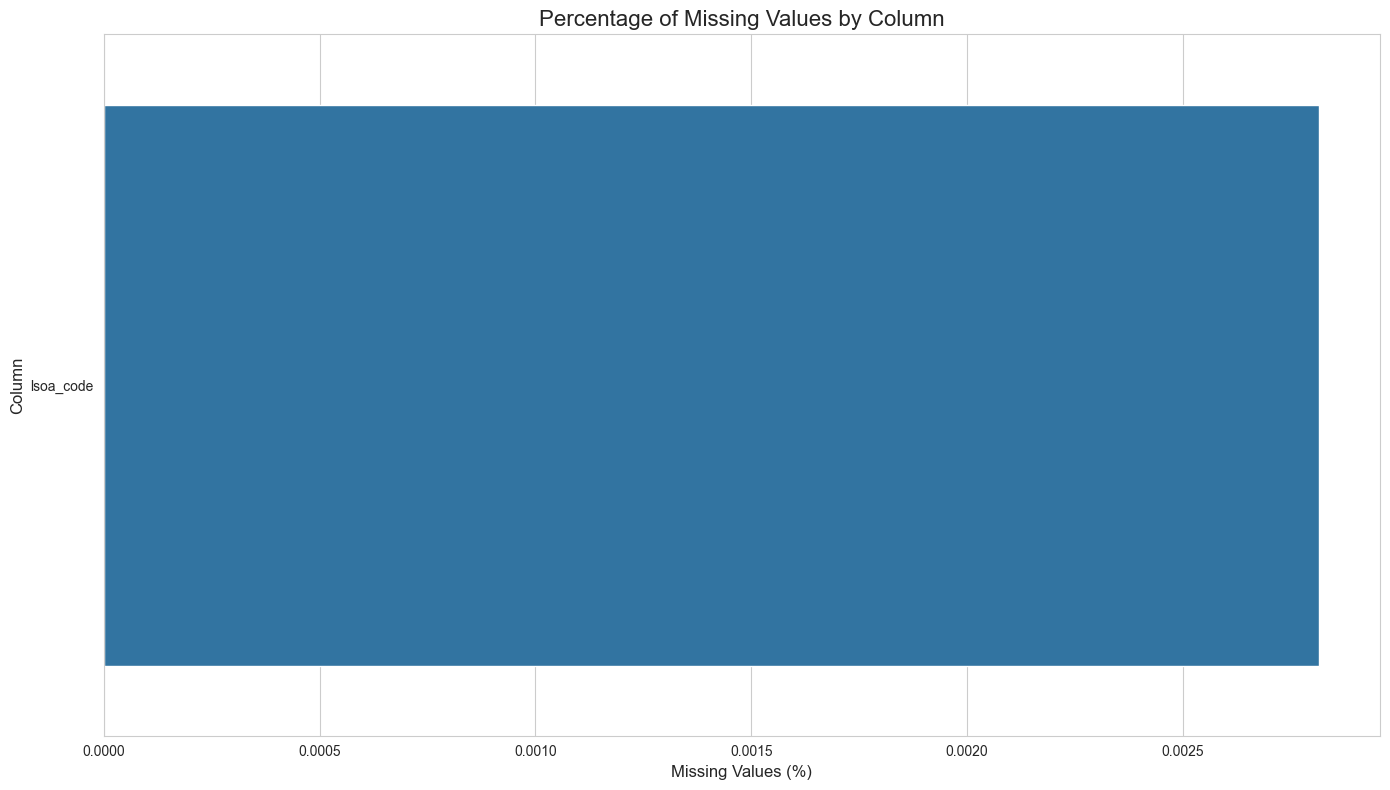

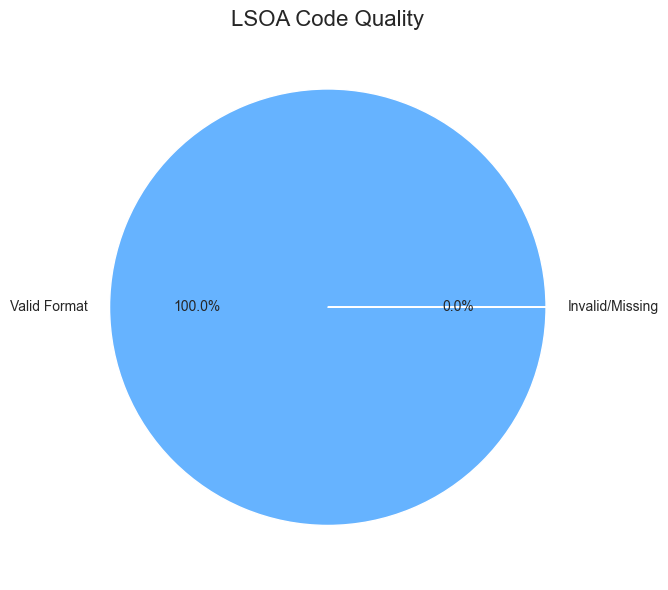

In [35]:
# Example usage function
def process_gmal_dataset():
    """
    Process the health authorities dataset by adding LSOA codes based on postcodes.
    """
    # Load the health authorities dataset
    gmal_file = "data/rawdata/transport/gmal.csv"
    gmal = pd.read_csv(gmal_file)

    # Set the path to the GM lookup file
    lookup_file = "data/gm_lookup.csv"

    # Set output directory for processed files
    output_dir = "data/preprocessed/transport"

    # Transform postcodes to LSOA codes and analyze the dataset
    enhanced_df, artifacts = transform_postcode_to_lsoa(
        df=gmal,
        postcode_column="PostCode",  # Use the actual column name from your dataset
        lookup_file=lookup_file,
        output_dir=output_dir,
        source_file=gmal_file  # Pass the actual file path
    )

    print(f"Processing complete. Enhanced dataset with LSOA codes saved to {artifacts['cleaned_file']}")

    # Additional Greater Manchester specific filtering
    # Filter for only Greater Manchester LSOAs if needed
    if 'lsoa_code' in enhanced_df.columns:
        # Check if the LSOA is in Greater Manchester (starts with 'E01')
        gm_lsoa_count = enhanced_df['lsoa_code'].str.startswith('E01').sum()
        print(f"Records with Greater Manchester LSOA codes: {gm_lsoa_count}/{len(enhanced_df)}")

    return enhanced_df, artifacts

# Run the function if this script is executed directly
if __name__ == "__main__":
    enhanced_df, artifacts = process_gmal_dataset()

In [40]:
df = pd.read_csv("data/preprocessed/transport/gmal_cleaned.csv")
df.head()

,postcode,eastings,northings,busscore,railscore,metroscore,locallinkscore,locallink,gmalscore,gmallevel,...,manchesterairport,manchestermarketstreet,manchesteroxfordroad,manchesterspinningfields,oldham,rochdale,stockport,traffordcentre,wigan,lsoa_code
0,WN5 7DP,351880,402534,0.000000,0.0,0.0,0.0,No,0.000000,1,...,>120,80,90,80,>120,>120,>120,>120,30,E01006366
1,WN5 7FS,352099,402807,1.753008,0.0,0.0,0.0,No,1.753008,2,...,100,70,80,70,110,>120,>120,110,30,E01006366
2,WN5 7FR,352137,402883,1.898256,0.0,0.0,0.0,No,1.898256,2,...,90,70,70,70,110,>120,110,110,30,E01006366
3,WN5 7FP,352173,402840,1.961143,0.0,0.0,0.0,No,1.961143,2,...,90,70,70,70,110,>120,110,110,30,E01006366
4,WN5 7FQ,352250,402911,2.072010,0.0,0.0,0.0,No,2.072010,2,...,90,70,70,70,110,>120,100,110,20,E01006366


In [41]:
columns_to_drop = ['eastings', 'northings']

df_cleaned = df.drop(columns=columns_to_drop)
df_cleaned.head()

,postcode,busscore,railscore,metroscore,locallinkscore,locallink,gmalscore,gmallevel,ptaltheme,altrincham,...,manchesterairport,manchestermarketstreet,manchesteroxfordroad,manchesterspinningfields,oldham,rochdale,stockport,traffordcentre,wigan,lsoa_code
0,WN5 7DP,0.000000,0.0,0.0,0.0,No,0.000000,1,1,>120,...,>120,80,90,80,>120,>120,>120,>120,30,E01006366
1,WN5 7FS,1.753008,0.0,0.0,0.0,No,1.753008,2,2,110,...,100,70,80,70,110,>120,>120,110,30,E01006366
2,WN5 7FR,1.898256,0.0,0.0,0.0,No,1.898256,2,2,110,...,90,70,70,70,110,>120,110,110,30,E01006366
3,WN5 7FP,1.961143,0.0,0.0,0.0,No,1.961143,2,2,110,...,90,70,70,70,110,>120,110,110,30,E01006366
4,WN5 7FQ,2.072010,0.0,0.0,0.0,No,2.072010,2,2,110,...,90,70,70,70,110,>120,100,110,20,E01006366


In [42]:
df_cleaned.to_csv('data/preprocessed/transport/gmal_cleaned2.csv', index=False)